# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")
from utils.s3_utils import download_file



all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

renamed_labels = ["Negative"] + [i.title() for i in label_names[1:]]

ptm_trigger_words =  ["phosphorylation", "deubiquitination", "acetylation", "ubiquitination", "methylation", "dephosphorylation"]



## Original inputs with markers
For how to create the preprocessed file for PTM-PPI, see https://github.com/elangovana/large-scale-ptm-ppi/blob/main/src/utils/static_markers_ppi_multiclass.py

In [2]:
temp_dir = "temp"

In [3]:
trainfile="../temp/markers_train_multiclass.json"
testfile="../temp/markers_test_multiclass.json"
valfile="../temp/markers_val_multiclass.json"


In [4]:
s3_generalisation = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2022-07-01_negative_generalisation/"
s3_large_scale_high_q = "{}/highquality_sample.json".format(s3_generalisation.rstrip("/"))
s3_large_scale_low_q = "{}/lowquality_sample.json".format(s3_generalisation.rstrip("/"))

## Predictions with markers

In [5]:
largescalefile = "../temp/markers_largescale_hq_above_threshold.json"
largescale_low_hq="../temp/markers_largescale_lq_below_threshold.json"

test_predictions_file ="../temp/markers_test_pred_multiclass.json"

In [6]:
def load_large_scale(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

def load_valtest_ensemble_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x) )
    df["y_raw"] = df["prediction"]


    return df

In [37]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"


def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class = 1000, classwise_vocab=True):
    
    max_tree_depth = 4
 
    
   
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier( min_df=min_df, max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("PROTPART1", "PROTPART0",  min_df=min_df,  max_words_per_class=max_words_per_class, stop_words=stop_words, ngram_range=ngram_range, classwise_vocab=classwise_vocab, trigger_words=ptm_trigger_words, max_tree_depth = max_tree_depth ),
 #      TREE : ModelTreeRelationClassifier("PROTPART1", "PROTPART0",  trigger_words=ptm_trigger_words, max_tree_depth=max_tree_depth)

    }
   
    
    result = {}
    
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result



def  predict_all_classifiers(df, models_dict):
    max_words_per_class = 10
    max_tree_depth = 4
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [8]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = renamed_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [9]:
def prep_data(df, m):
    df_t = df.copy(deep=True)
    df_t["nb_pred"] = m["predictions"]
    df_t["nb_pred_conf"] = m["predictions_conf"]
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),1, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        ax[i].set_ylim(0,1)


        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')



        ax[i].violinplot(t["confidence"],  showmeans=True )
        ax[i].set_title(f"{l}")


# plot_confidence(prep_data(df_largescale_hq, result_largescale_hq[NAIVE_BAYES_WITH_TREE]))

# plt.show()




In [10]:
from dtreeviz.trees import *

def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)

    plt.show()
    
def plot_tree_pretty(m, x, y, title="", image_save_path=None):
    import sys
    dot_path = '/opt/homebrew/bin/'
    if dot_path not in sys.path :
        sys.path.append( dot_path)
        for p in sys.path:
            os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

    viz = dtreeviz(m.tree_model,
               x_data=m.extract_features(x),
               y_data=y,
               target_name='class',
               feature_names=m.feature_names,
               class_names=label_names,
               title=title)
    
    return viz
    # tree_plt.view()    
    if image_save_path:
        tree_plt.save(image_save_path)

In [11]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}
    
    #. ( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])]

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

## Train GT Train predictions

In [13]:
df_train = pd.read_json(trainfile, orient="records")
train_result = train_and_predict_all_classifiers(df_train)

print_report_all_classifiers(df_train["y"], train_result,  pos_labels)

print_report_all_classifiers(df_train["y"], train_result,  all_labels)



Training Naive Bayes
Max words :  562
Training Naive Bayes + Tree
Max words :  562
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      33.4 &   Phosphorylation &   79.9 &     47.1 &     139 \\
       Naive Bayes &      20.6 & Dephosphorylation &   78.6 &     32.6 &      28 \\
       Naive Bayes &      31.2 &       Methylation &  100.0 &     47.6 &      10 \\
       Naive Bayes &      17.9 &    Ubiquitination &  100.0 &     30.3 &       5 \\
       Naive Bayes &      16.0 &       Acetylation &   80.0 &     26.7 &       5 \\
       Naive Bayes &      33.3 &  Deubiquitination &   50.0 &     40.0 &       2 \\
       Naive Bayes &      29.0 &         micro avg &   81.0 &     42.7 &     189 \\
       Naive Bayes &      25.4 &         macro avg &   81.4 &     37.4 &     189 \\
       Naive Bayes &      30.5 &      weighted avg &   81.0 &     43.9 &     189 \\
Naive Bayes + Tree &      76.9 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.957584,Negative,0.667563,0.786695,1116.000000
Phosphorylation,Naive Bayes,0.334337,Phosphorylation,0.798561,0.471338,139.000000
Dephosphorylation,Naive Bayes,0.205607,Dephosphorylation,0.785714,0.325926,28.000000
Methylation,Naive Bayes,0.312500,Methylation,1.000000,0.476190,10.000000
Ubiquitination,Naive Bayes,0.178571,Ubiquitination,1.000000,0.303030,5.000000
Acetylation,Naive Bayes,0.160000,Acetylation,0.800000,0.266667,5.000000
Deubiquitination,Naive Bayes,0.333333,Deubiquitination,0.500000,0.400000,2.000000
accuracy,Naive Bayes,0.688123,accuracy,0.688123,0.688123,0.688123
macro avg,Naive Bayes,0.354562,macro avg,0.793120,0.432835,1305.000000
weighted avg,Naive Bayes,0.863125,weighted avg,0.688123,0.736401,1305.000000


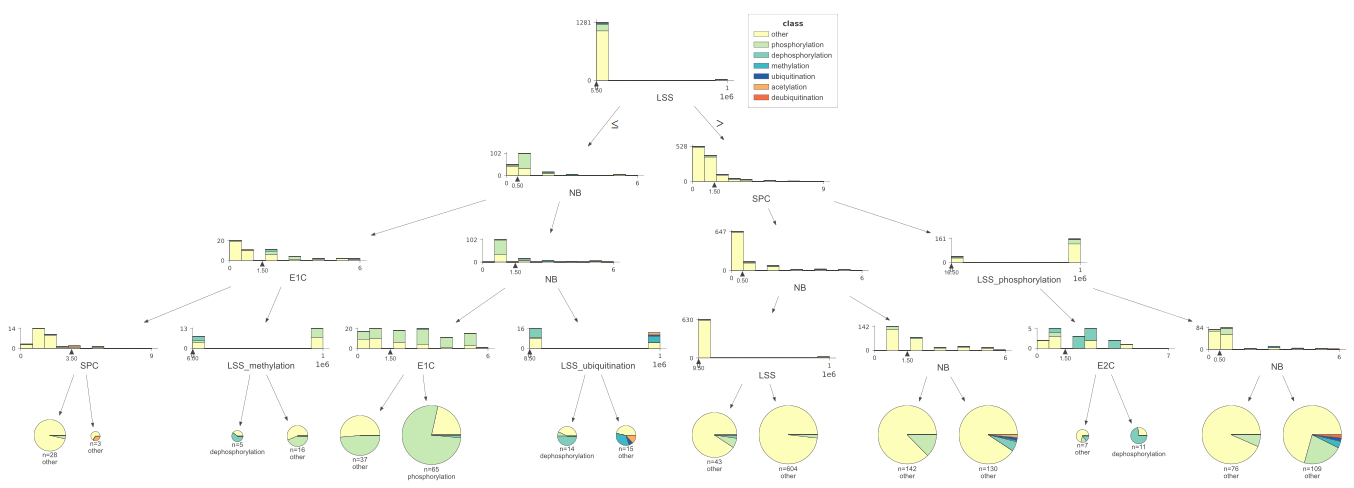

In [14]:
#plot_tree(train_result[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(train_result[NAIVE_BAYES_WITH_TREE]["m"], df_train["x"], df_train["y"])

In [15]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

[('prtig0', -3.0027935609077883),
 ('protpart1', -3.128313579066324),
 ('protpart0', -3.1336676926110503),
 ('prtig1', -3.17603635193554),
 ('prtig2', -3.3813284814603772),
 ('prtig3', -3.5557414127944043),
 ('phosphorylation', -3.6139731053846127),
 ('cells', -4.142040535585109),
 ('kinase', -4.174674294778412),
 ('protein', -4.195624781719215),
 ('prtig4', -4.20626695381536),
 ('activation', -4.227168615641925),
 ('cell', -4.418415537122199),
 ('induced', -4.627548351366809),
 ('tyrosine', -4.662950278417726),
 ('activity', -4.7173303614369475),
 ('phosphorylated', -4.7900672808645846),
 ('proteins', -4.841225976692137),
 ('signaling', -4.95816818155821),
 ('binding', -4.99987306697267),
 ('kinases', -5.045042035340582),
 ('domain', -5.082021038581669),
 ('results', -5.082021038581669),
 ('dependent', -5.108041587283565),
 ('response', -5.1311537271593135),
 ('complex', -5.14200374318338),
 ('expression', -5.14564673446188),
 ('prtig5', -5.158502742563415),
 ('vitro', -5.211646176239

In [16]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)

[('protpart1', -2.4621215573829938),
 ('protpart0', -2.579767239835398),
 ('prtig0', -3.3433209694458785),
 ('phosphorylation', -3.591986389555208),
 ('prtig1', -3.6022428897223966),
 ('kinase', -4.018070784866108),
 ('prtig2', -4.139767719843627),
 ('cells', -4.187969821661506),
 ('protein', -4.219320351545582),
 ('activation', -4.385217028672136),
 ('cell', -4.385217028672136),
 ('activity', -4.463381801521472),
 ('phosphorylated', -4.49644266378236),
 ('induced', -4.721689265293349),
 ('tyrosine', -4.7982293424156826),
 ('prtig3', -4.844749358050576),
 ('binding', -4.918857330204298),
 ('human', -5.012886279852574),
 ('vitro', -5.04145965229663),
 ('response', -5.085911414867464),
 ('signaling', -5.085911414867464),
 ('domain', -5.101178886998253),
 ('proteins', -5.132431430502357),
 ('kinases', -5.148431771848798),
 ('results', -5.19802871298817),
 ('dna', -5.21512314634747),
 ('complex', -5.21512314634747),
 ('expression', -5.232514889059339),
 ('dependent', -5.25021446615874),
 (

## Val GT predictions


In [17]:
df_val = pd.read_json(valfile, orient="records")
result_val = train_and_predict_all_classifiers(df_val, min_df=1)

print_report_all_classifiers(df_val["y"], result_val,  pos_labels)

print_report_all_classifiers(df_val["y"], result_val,  all_labels)



Training Naive Bayes
Max words :  999
Training Naive Bayes + Tree
Max words :  999
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      42.4 &   Phosphorylation &   66.7 &     51.9 &      21 \\
       Naive Bayes &      29.0 & Dephosphorylation &   90.0 &     43.9 &      10 \\
       Naive Bayes &      16.7 &       Methylation &  100.0 &     28.6 &       1 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &      33.3 &       Acetylation &  100.0 &     50.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      32.9 &         micro avg &   76.5 &     46.0 &      34 \\
       Naive Bayes &      23.0 &         macro avg &   76.1 &     33.8 &      34 \\
       Naive Bayes &      36.7 &      weighted avg &   76.5 &     48.1 &      34 \\
Naive Bayes + Tree &      81.8 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.933884,Negative,0.680723,0.787456,166.0
Phosphorylation,Naive Bayes,0.424242,Phosphorylation,0.666667,0.518519,21.0
Dephosphorylation,Naive Bayes,0.290323,Dephosphorylation,0.900000,0.439024,10.0
Methylation,Naive Bayes,0.166667,Methylation,1.000000,0.285714,1.0
Ubiquitination,Naive Bayes,0.166667,Ubiquitination,1.000000,0.285714,1.0
Acetylation,Naive Bayes,0.333333,Acetylation,1.000000,0.500000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.695000,micro avg,0.695000,0.695000,200.0
macro avg,Naive Bayes,0.330731,macro avg,0.749627,0.402347,200.0
weighted avg,Naive Bayes,0.837519,weighted avg,0.695000,0.735342,200.0


## Test 

### Predict Test on Test GT fit

In [18]:
df_test = pd.read_json(testfile, orient="records")
result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)

# df_test["train_shortcut_pred"] = m.predict(df_test["x"])[0]
print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)

print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

l_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt,  pos_labels)


Training Naive Bayes
Max words :  1313
Training Naive Bayes + Tree
Max words :  1313
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      27.3 &   Phosphorylation &   86.4 &     41.5 &      44 \\
       Naive Bayes &      22.7 & Dephosphorylation &   83.3 &     35.7 &       6 \\
       Naive Bayes &      19.0 &       Methylation &  100.0 &     32.0 &       4 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      25.5 &         micro avg &   85.7 &     39.3 &      56 \\
       Naive Bayes &      14.3 &         macro avg &   61.6 &     23.0 &      56 \\
       Naive Bayes &      25.6 &      weighted avg &   85.7 &     39.3 &      56 \\
Naive Bayes + Tree &      64.3 & 

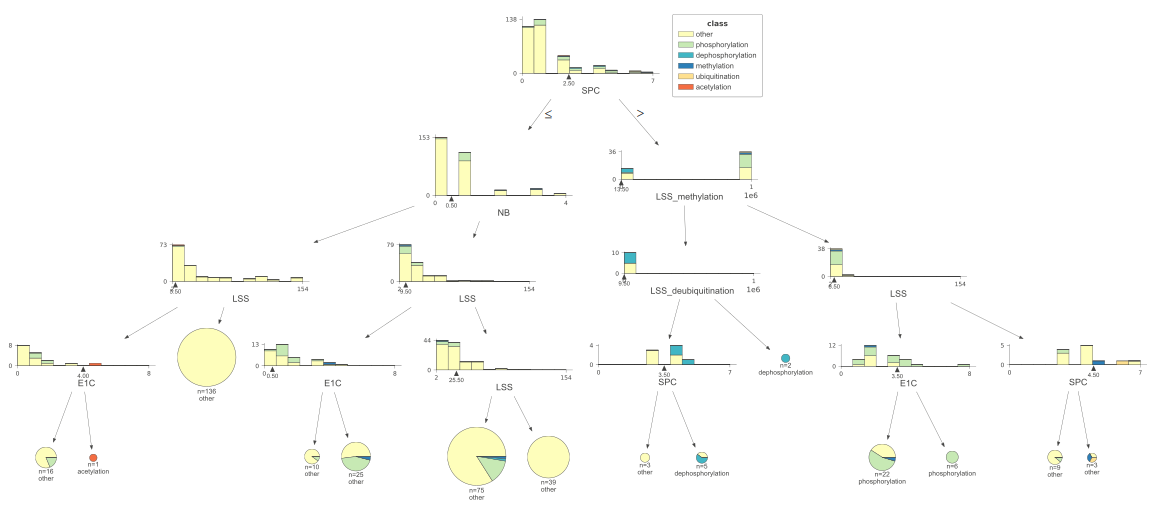

In [19]:
#plot_tree(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"])

plot_tree_pretty(result_test_gt[NAIVE_BAYES_WITH_TREE]["m"], df_test["x"], df_test["y"])

### Test on train fit

In [20]:
result_train_predict_test_gt = predict_all_classifiers(df_test, result_test_gt)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      95.1 &          Negative &   52.7 &     67.8 &     296 \\
       Naive Bayes &      27.3 &   Phosphorylation &   86.4 &     41.5 &      44 \\
       Naive Bayes &      22.7 & Dephosphorylation &   83.3 &     35.7 &       6 \\
       Naive Bayes &      19.0 &       Methylation &  100.0 &     32.0 &       4 \\
       Naive Bayes &      16.7 &    Ubiquitination &  100.0 &     28.6 &       1 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      58.0 &         micro avg &   58.0 &     58.0 &     352 \\
       Naive Bayes &      25.8 &         macro avg &   60.3 &     29.4 &     352 \\
       Naive Bayes &      84.1 &      weighted avg &   58.0 &     63.3 &     352 \\
Naive Bayes + Tree &      90.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.951220,Negative,0.527027,0.678261,296.0
Phosphorylation,Naive Bayes,0.273381,Phosphorylation,0.863636,0.415301,44.0
Dephosphorylation,Naive Bayes,0.227273,Dephosphorylation,0.833333,0.357143,6.0
Methylation,Naive Bayes,0.190476,Methylation,1.000000,0.320000,4.0
Ubiquitination,Naive Bayes,0.166667,Ubiquitination,1.000000,0.285714,1.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.579545,micro avg,0.579545,0.579545,352.0
macro avg,Naive Bayes,0.258431,macro avg,0.603428,0.293774,352.0
weighted avg,Naive Bayes,0.840574,weighted avg,0.579545,0.632804,352.0


### Predict Test on Test Prediction fit 

In [21]:
df_test_prediction = load_valtest_ensemble_pred(test_predictions_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)



l_test_pred =  print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)


Training Naive Bayes
Max words :  1297
Training Naive Bayes + Tree
Max words :  1297
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      21.7 &   Phosphorylation &   95.8 &     35.4 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      22.5 &         micro avg &   93.5 &     36.2 &      31 \\
       Naive Bayes &      12.8 &         macro avg &   49.3 &     19.9 &      31 \\
       Naive Bayes &      23.0 &      weighted avg &   93.5 &     36.5 &      31 \\
Naive Bayes + Tree &      76.0 & 

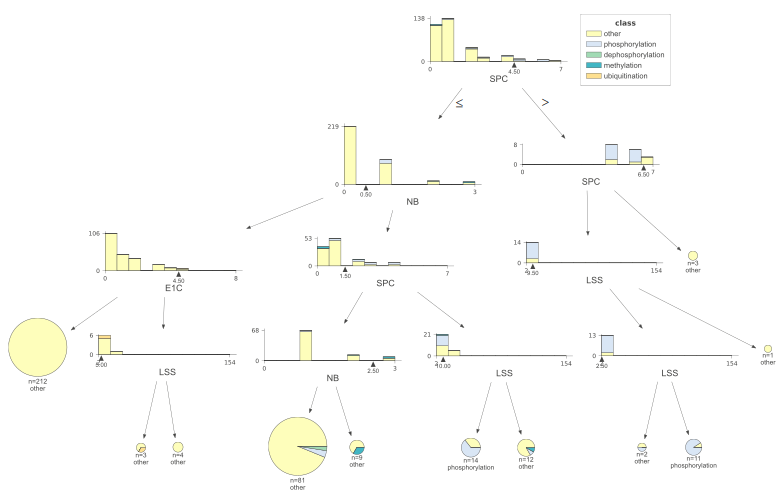

In [22]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
plot_tree_pretty(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"], df_test_prediction["x"], df_test_prediction["y"])

In [23]:
t = l_test_pred.merge(l_test_gt,  on =["model", "index"])

print(t.to_latex(index=False, float_format= lambda x: f"{x:.1%}").replace("\%",""))

\begin{tabular}{lrlrrrrrrr}
\toprule
             model &  precision\_x &             index &  recall\_x &  f1-score\_x &  support\_x &  precision\_y &  recall\_y &  f1-score\_y &  support\_y \\
\midrule
       Naive Bayes &        21.7 &   Phosphorylation &     95.8 &       35.4 &    2400.0 &        27.3 &     86.4 &       41.5 &    4400.0 \\
       Naive Bayes &        15.4 & Dephosphorylation &    100.0 &       26.7 &     200.0 &        22.7 &     83.3 &       35.7 &     600.0 \\
       Naive Bayes &        40.0 &       Methylation &    100.0 &       57.1 &     400.0 &        19.0 &    100.0 &       32.0 &     400.0 \\
       Naive Bayes &         0.0 &    Ubiquitination &      0.0 &        0.0 &       0.0 &        16.7 &    100.0 &       28.6 &     100.0 \\
       Naive Bayes &         0.0 &       Acetylation &      0.0 &        0.0 &     100.0 &         0.0 &      0.0 &        0.0 &     100.0 \\
       Naive Bayes &         0.0 &  Deubiquitination &      0.0 &        0.0 &       0

### Test prediction on train fit

In [24]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, result_test_bp)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)



\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.1 &          Negative &   68.8 &     81.2 &     321 \\
       Naive Bayes &      21.7 &   Phosphorylation &   95.8 &     35.4 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.0 &         micro avg &   71.0 &     71.0 &     352 \\
       Naive Bayes &      25.2 &         macro avg &   52.1 &     28.6 &     352 \\
       Naive Bayes &      92.4 &      weighted avg &   71.0 &     77.3 &     352 \\
Naive Bayes + Tree &      96.3 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.991031,Negative,0.688474,0.812500,321.0
Phosphorylation,Naive Bayes,0.216981,Phosphorylation,0.958333,0.353846,24.0
Dephosphorylation,Naive Bayes,0.153846,Dephosphorylation,1.000000,0.266667,2.0
Methylation,Naive Bayes,0.400000,Methylation,1.000000,0.571429,4.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,1.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.710227,micro avg,0.710227,0.710227,352.0
macro avg,Naive Bayes,0.251694,macro avg,0.520972,0.286349,352.0
weighted avg,Naive Bayes,0.923967,weighted avg,0.710227,0.773079,352.0


## Fit large scale Negative high quality

In [25]:

local_hq_file= os.path.join(temp_dir, s3_large_scale_high_q.split("/")[-1])

download_file(s3_large_scale_high_q , temp_dir)

t = load_large_scale(local_hq_file)


df_largescale_negative_sample_hq = pd.concat([t.query("y==0").sample(n=5000, random_state=43),
                                              t.query("y==1").sample(n=250, random_state=43)])


result_largescale_negative_sample_hq  = train_and_predict_all_classifiers(df_largescale_negative_sample_hq)



print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)





Training Naive Bayes
Max words :  139
Training Naive Bayes + Tree
Max words :  139
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      63.7 &   Phosphorylation &   94.0 &     75.9 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      63.7 &         micro avg &   94.0 &     75.9 &     250 \\
       Naive Bayes &      10.6 &         macro avg &   15.7 &     12.7 &     250 \\
       Naive Bayes &      63.7 &      weighted avg &   94.0 &     75.9 &     250 \\
Naive Bayes + Tree &      81.4 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.996927,Negative,0.973200,0.984921,5000.0
Phosphorylation,Naive Bayes,0.636856,Phosphorylation,0.940000,0.759289,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.971619,micro avg,0.971619,0.971619,5250.0
macro avg,Naive Bayes,0.233398,macro avg,0.273314,0.249173,5250.0
weighted avg,Naive Bayes,0.979781,weighted avg,0.971619,0.974176,5250.0


In [26]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"],0)

[('prtig0', -2.65730455276314),
 ('prtig1', -2.837874034034364),
 ('cells', -2.980144030540872),
 ('protpart1', -3.121885454973139),
 ('prtig2', -3.12913916398961),
 ('protpart0', -3.1327858455024593),
 ('cell', -3.4656518463225723),
 ('prtig3', -3.5034466230392276),
 ('expression', -3.7418859191115175),
 ('prtig4', -3.8522557467481224),
 ('human', -4.176220572744581),
 ('prtig5', -4.272626137628599),
 ('protein', -4.365654658438253),
 ('gene', -4.4790947705658075),
 ('induced', -4.547280078761353),
 ('growth', -4.54769770248845),
 ('prtig6', -4.57565377975504),
 ('proteins', -4.6839778270498025),
 ('activity', -4.68541495304565),
 ('mrna', -4.715587558199012),
 ('binding', -4.7451710643030065),
 ('levels', -4.756430139228928),
 ('prtig7', -4.879502486062168),
 ('factor', -4.897118913450465),
 ('effect', -4.900085394415562),
 ('results', -4.910838186191824),
 ('expressed', -4.9241394705691),
 ('genes', -4.925967067788124),
 ('activation', -4.960710016231997),
 ('anti', -4.9676786855480

In [27]:
get_top_discrimintary_keywords(result_largescale_negative_sample_hq[NAIVE_BAYES]["m"] ,1)

[('protpart1', -2.174515621849019),
 ('protpart0', -2.1859117565798885),
 ('phosphorylation', -2.919005797350686),
 ('protein', -3.130782782007831),
 ('kinase', -3.259062981049725),
 ('cells', -3.396592779640943),
 ('activity', -3.76431755976626),
 ('phosphorylated', -3.792488436732957),
 ('cell', -3.913849293737224),
 ('prtig0', -4.2797835630887535),
 ('tyrosine', -4.360472474338896),
 ('proteins', -4.4574647403262055),
 ('dependent', -4.534425781462334),
 ('human', -4.564884988947043),
 ('activation', -4.606996474297169),
 ('binding', -4.606996474297169),
 ('results', -4.628736460933576),
 ('vitro', -4.628736460933576),
 ('purified', -4.732876720186172),
 ('specific', -4.822107853914115),
 ('stimulated', -4.835530874246255),
 ('increase', -4.9200882622743185),
 ('increased', -4.949941225424),
 ('induced', -4.949941225424),
 ('receptor', -4.965208697554789),
 ('factor', -4.980712884090754),
 ('chain', -5.028722103277114),
 ('site', -5.028722103277114),
 ('muscle', -5.028722103277114),

### Fit to train

In [28]:
result_train_predict_largescale_negative_sample_hq = predict_all_classifiers(df_largescale_negative_sample_hq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq, all_labels)

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.5 &          Negative &   83.9 &     91.0 &    5000 \\
       Naive Bayes &      23.4 &   Phosphorylation &   79.2 &     36.1 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      83.7 &          accuracy &   83.7 &     83.7 &       0 \\
       Naive Bayes &      17.6 &         macro avg &   23.3 &     18.2 &    5250 \\
       Naive Bayes &      95.9 &      weighted avg &   83.7 &     88.4 &    5250 \\
Naive Bayes + Tree &      95.7 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.995490,Negative,0.838800,0.910453,5000.000000
Phosphorylation,Naive Bayes,0.234043,Phosphorylation,0.792000,0.361314,250.000000
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.000000
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.000000
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.000000
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.000000
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.000000
accuracy,Naive Bayes,0.836571,accuracy,0.836571,0.836571,0.836571
macro avg,Naive Bayes,0.175648,macro avg,0.232971,0.181681,5250.000000
weighted avg,Naive Bayes,0.959231,weighted avg,0.836571,0.884303,5250.000000


## Fit large scale Negative low quality

In [29]:
local_lq_file= os.path.join(temp_dir, s3_large_scale_low_q.split("/")[-1])

download_file(s3_large_scale_low_q , temp_dir)



df_largescale_negative_sample_lq = load_large_scale(local_lq_file)
df_largescale_negative_sample_lq = pd.concat([df_largescale_negative_sample_lq.query("y==0").sample(n=5000, random_state=43),
                                              df_largescale_negative_sample_lq.query("y==1").sample(n=250, random_state=43 )])


result_largescale_negative_sample_lq  = train_and_predict_all_classifiers(df_largescale_negative_sample_lq)



print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, pos_labels)

print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)






Training Naive Bayes
Max words :  113
Training Naive Bayes + Tree
Max words :  113
\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      26.1 &   Phosphorylation &   43.2 &     32.5 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      26.1 &         micro avg &   43.2 &     32.5 &     250 \\
       Naive Bayes &       4.3 &         macro avg &    7.2 &      5.4 &     250 \\
       Naive Bayes &      26.1 &      weighted avg &   43.2 &     32.5 &     250 \\
Naive Bayes + Tree &      86.7 &   

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.970637,Negative,0.938800,0.954453,5000.0
Phosphorylation,Naive Bayes,0.260870,Phosphorylation,0.432000,0.325301,250.0
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.0
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.0
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.0
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.0
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.0
micro avg,Naive Bayes,0.914667,micro avg,0.914667,0.914667,5250.0
macro avg,Naive Bayes,0.175929,macro avg,0.195829,0.182822,5250.0
weighted avg,Naive Bayes,0.936838,weighted avg,0.914667,0.924493,5250.0


In [30]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],0)

[('protpart0', -2.58255846351703),
 ('protpart1', -2.6086985022290285),
 ('cells', -2.869739408421365),
 ('prtig0', -3.113099658614031),
 ('cell', -3.4283800364982646),
 ('activity', -3.938836928696656),
 ('prtig1', -3.987627092866088),
 ('human', -4.16428728610878),
 ('protein', -4.203538792653802),
 ('expression', -4.322423315429012),
 ('induced', -4.335584385816462),
 ('binding', -4.349847337521245),
 ('levels', -4.455825900170315),
 ('patients', -4.458921877875443),
 ('effect', -4.460991200910811),
 ('10', -4.477175318184793),
 ('results', -4.56514409113075),
 ('beta', -4.591936608127326),
 ('specific', -4.593709134440745),
 ('increased', -4.619466772869908),
 ('gene', -4.633521388575487),
 ('alpha', -4.642174100162351),
 ('acid', -4.6853006309761644),
 ('response', -4.697034794297813),
 ('growth', -4.716902997514539),
 ('anti', -4.748155541018643),
 ('proteins', -4.787569509559519),
 ('receptor', -4.815966029867105),
 ('increase', -4.818184145379126),
 ('effects', -4.8528261635825

In [31]:
get_top_discrimintary_keywords(result_largescale_negative_sample_lq[NAIVE_BAYES]["m"],1)

[('protpart1', -2.055322462734109),
 ('protpart0', -2.170241113926811),
 ('cells', -3.387503150371429),
 ('prtig0', -3.6674117244898294),
 ('activity', -3.7796790263609106),
 ('human', -3.9061631734700306),
 ('cell', -3.9288914245475866),
 ('levels', -4.09751413698338),
 ('patients', -4.2127494005609645),
 ('protein', -4.283925679028859),
 ('expression', -4.3172620992964506),
 ('plasma', -4.325772788964359),
 ('gene', -4.41511788930021),
 ('binding', -4.433986373604593),
 ('effect', -4.492826873627526),
 ('alpha', -4.577087217245266),
 ('induced', -4.577087217245266),
 ('results', -4.599310354029976),
 ('normal', -4.622038605107532),
 ('increased', -4.645295467271799),
 ('beta', -4.657129924918802),
 ('acid', -4.7441413019084315),
 ('serum', -4.757213383475785),
 ('significantly', -4.7704586102258055),
 ('10', -4.81128060474606),
 ('factor', -4.8252668467208),
 ('observed', -4.839451481712756),
 ('proteins', -4.839451481712756),
 ('concentrations', -4.853840219164856),
 ('specific', -4

### Fit to train

In [32]:


result_train_predict_largescale_negative_sample_low_q = predict_all_classifiers(df_largescale_negative_sample_lq, train_result) 
 
print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q, all_labels)


\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      98.4 &          Negative &   24.1 &     38.7 &    5000 \\
       Naive Bayes &       6.7 &   Phosphorylation &   59.2 &     12.0 &     250 \\
       Naive Bayes &       0.0 & Dephosphorylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Methylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      25.8 &          accuracy &   25.8 &     25.8 &       0 \\
       Naive Bayes &      15.0 &         macro avg &   11.9 &      7.2 &    5250 \\
       Naive Bayes &      94.1 &      weighted avg &   25.8 &     37.4 &    5250 \\
Naive Bayes + Tree &      95.2 &  

,model,precision,index,recall,f1-score,support
Negative,Naive Bayes,0.984477,Negative,0.241000,0.387211,5000.000000
Phosphorylation,Naive Bayes,0.066607,Phosphorylation,0.592000,0.119741,250.000000
Dephosphorylation,Naive Bayes,0.000000,Dephosphorylation,0.000000,0.000000,0.000000
Methylation,Naive Bayes,0.000000,Methylation,0.000000,0.000000,0.000000
Ubiquitination,Naive Bayes,0.000000,Ubiquitination,0.000000,0.000000,0.000000
Acetylation,Naive Bayes,0.000000,Acetylation,0.000000,0.000000,0.000000
Deubiquitination,Naive Bayes,0.000000,Deubiquitination,0.000000,0.000000,0.000000
accuracy,Naive Bayes,0.257714,accuracy,0.257714,0.257714,0.257714
macro avg,Naive Bayes,0.150155,macro avg,0.119000,0.072422,5250.000000
weighted avg,Naive Bayes,0.940769,weighted avg,0.257714,0.374474,5250.000000


Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  2323
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  2323
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  1896
Training Naive Bayes
Max words :  5000


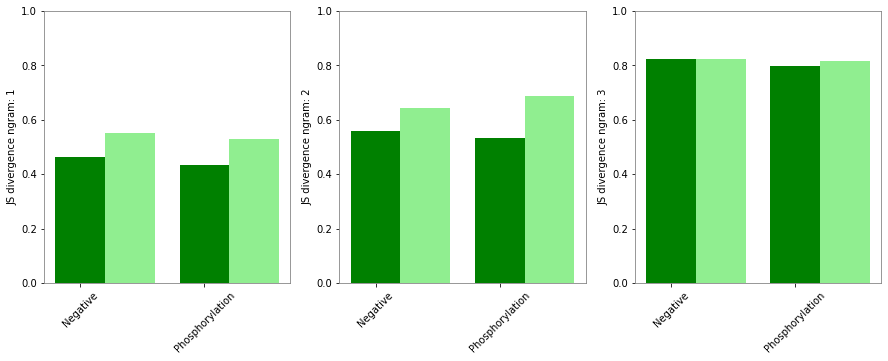

In [46]:
import numpy as np
import math
from scipy.spatial import distance



def _build_list(l1,l2, use_common_only=True):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
           
    if use_common_only:
        intersection = set([w for w,_ in l2]).intersection(set([w for w,_ in l1]))
        word_index = {w:i for i,w in enumerate(intersection)}


    
    l1_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l1)):        
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l2)):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r

def js_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return distance.jensenshannon(p,q, 2.71828)



def compute_js_divergence(p1_model_result, p2_model_result, label_names=renamed_labels[:2], use_common_only=False):
    result = []
    for i, l in enumerate(label_names):
        p = js_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i),
                          use_common_only=use_common_only
                     )
        result.append({
            "label_name" : l,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)

def plot_divergence(df1,t1, df2, t2, ax, suffix_y_label):
    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.4
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"], rotation = 45)
    
    ax.set_ylim(0,1)
    
    ax.set_ylabel(f"JS divergence {suffix_y_label}")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')



_, axes= plt.subplots(1,3, figsize=(15,5))  


classifiers = {NAIVE_BAYES}

kwargs = {
    "ngram_range":(1,1),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  5000
}



ax = axes[0]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 1")

ax.legend().remove()

kwargs = {
    "ngram_range":(2,2),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  5000
}



ax = axes[1]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 2")

ax.legend().remove()




kwargs = {
    "ngram_range":(3,3),
   "min_df": 5,
   "stop_words":'english',
    "classifiers":classifiers,
    "max_words_per_class" :  5000,
    "classwise_vocab":False
}

ax = axes[2]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_hq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_largescale_negative_sample_lq, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 3")

ax.legend().remove()



## Latex results

In [47]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)
df_summ_negative_sample_lq = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_largescale_negative_sample_lq, all_labels)

df_summ_negative_sample_hq = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_largescale_negative_sample_hq, all_labels)




df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_lq, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},
     {"df": df_summ_negative_sample_hq, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]}




                ],


              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.1 &          Negative &   68.8 &     81.2 &     321 \\
       Naive Bayes &      21.7 &   Phosphorylation &   95.8 &     35.4 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.0 &         micro avg &   71.0 &     71.0 &     352 \\
       Naive Bayes &      25.2 &         macro avg &   52.1 &     28.6 &     352 \\
       Naive Bayes &      92.4 &      weighted avg &   71.0 &     77.3 &     352 \\
Naive Bayes + Tree &      96.3 &  

In [48]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)
df_summ_trainfit_large_high = print_report_all_classifiers(df_largescale_negative_sample_hq["y"], result_train_predict_largescale_negative_sample_hq,  all_labels)
df_summ_trainfit_large_low = print_report_all_classifiers(df_largescale_negative_sample_lq["y"], result_train_predict_largescale_negative_sample_low_q,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Negative"]
              )

print("**Negative***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_high, "meta":[{ "name": "dataset" , "value": "PTM GH"}, { "name": "T" , "value": "BP"}]},
                {"df": df_summ_trainfit_large_low, "meta":[{ "name": "dataset" , "value": "PTM GL"}, { "name": "T" , "value": "BP"}]},





                ],
    index_filter=["Phosphorylation"]
              )

print("**Phosphorylation***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.1 &          Negative &   68.8 &     81.2 &     321 \\
       Naive Bayes &      21.7 &   Phosphorylation &   95.8 &     35.4 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.0 &         micro avg &   71.0 &     71.0 &     352 \\
       Naive Bayes &      25.2 &         macro avg &   52.1 &     28.6 &     352 \\
       Naive Bayes &      92.4 &      weighted avg &   71.0 &     77.3 &     352 \\
Naive Bayes + Tree &      96.3 &  

In [49]:
def prepare_latex(meta_dict_df):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ


df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["y"], result_test_gt, all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)



df_summ = prepare_latex ([
                {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{lrlrrr}
\toprule
             model & precision &             index & recall & f1-score & support \\
\midrule
       Naive Bayes &      99.1 &          Negative &   68.8 &     81.2 &     321 \\
       Naive Bayes &      21.7 &   Phosphorylation &   95.8 &     35.4 &      24 \\
       Naive Bayes &      15.4 & Dephosphorylation &  100.0 &     26.7 &       2 \\
       Naive Bayes &      40.0 &       Methylation &  100.0 &     57.1 &       4 \\
       Naive Bayes &       0.0 &    Ubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &       0.0 &       Acetylation &    0.0 &      0.0 &       1 \\
       Naive Bayes &       0.0 &  Deubiquitination &    0.0 &      0.0 &       0 \\
       Naive Bayes &      71.0 &         micro avg &   71.0 &     71.0 &     352 \\
       Naive Bayes &      25.2 &         macro avg &   52.1 &     28.6 &     352 \\
       Naive Bayes &      92.4 &      weighted avg &   71.0 &     77.3 &     352 \\
Naive Bayes + Tree &      96.3 &  